In [7]:
%matplotlib inline
import pandas
import seaborn
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
plt.rc('figure', figsize=(12,8))

## Recap: Nonlinear solver costs

* for each nonlinear iteration
  * compute residual $F(u)$
  * assemble matrix $J(u) = F'(u)$
  * setup preconditioner $M^{-1}(J, \dotsc)$
  * for each linear iteration
    * apply preconditioner $M^{-1} v$
    * apply Jacobian $J v$
    * Krylov vector work/inner products

#### Shifting costs
* Approximate Jacobian
* Less expensive preconditioner `-pc_type jacobi`
* Lag the preconditioner `-snes_lag_preconditioner`
* Lag the Jacobian `-snes_lag_jacobian`
* Matrix-free finite differencing to skip assembly of Jacobian `-snes_mf` or `-snes_mf_operator`

A good PETSc example to test with: `src/snes/examples/tutorials/ex15.c`

## Transient problems

When solving time-dependent problems such as

$$ \dot u := \frac{\partial u(x,t)}{\partial t} = f\big(u(x,t), t\big) $$

we have a choice between explicit methods and implicit methods.  Explicit methods only require that we evaluate $f(u,t)$ on each time step while implicit methods require solves (linear or nonlinear).  To get a handle on this choice, we have to understand **stability** and **stiffness**.  First, we consider an explicit method for a scalar model problem,

$$ \dot u = -k (u - \cos t) $$

where $k$ is a parameter controlling the rate at which the solution $u(t)$ is pulled toward the curve $\cos t$.

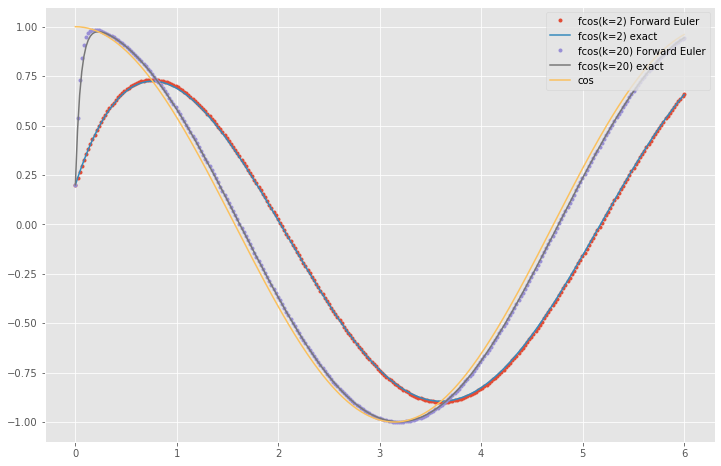

In [71]:
def ode_euler(f, u0, tfinal=1, h=0.1):
    u = np.array(u0)
    t = 0
    thist = [t]
    uhist = [u0]
    while t < tfinal:
        h = min(h, tfinal - t)
        u += h * f(t, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return np.array(thist), np.array(uhist)

tests = []

class fcos:
    def __init__(self, k=5):
        self.k = k
    def __repr__(self):
        return 'fcos(k={:d})'.format(self.k)
    def f(self, t, u):
        return -self.k * (u - np.cos(t))
    def u(self, t, u0):
        k2p1 = self.k**2+1
        return (u0 - self.k**2/k2p1) * np.exp(np.array(-self.k*t)) + self.k*(np.sin(t) + self.k*np.cos(t))/k2p1

tests.append(fcos(k=2))
tests.append(fcos(k=20))

u0 = np.array([.2])
for test in tests:
    thist, uhist = ode_euler(test.f, u0, h=.021, tfinal=6)
    plt.plot(thist, uhist, '.', label=repr(test)+' Forward Euler')
    plt.plot(thist, test.u(thist, u0), label=repr(test)+' exact')
plt.plot(thist, np.cos(thist), label='cos')
plt.legend(loc='upper right');

As we increase the parameter $k$, we observe a greater separation of scales between the fast relaxation (characteristic time $1/k$) and the slow dynamics dictated by `cos(t)`, which has characteristic time 1.  After the initial transient, we could approximate the solution accurately with large time steps, but the Forward Euler method that we're using here is unstable.  We'll now investigate why.

### Linear Stability Analysis

Why did forward Euler diverge and how can we characterize methods that enable long time steps?  We can answer this by considering the test equation
$$ \dot u = \lambda u $$
and applying each method to construct
$$ \tilde u(h) = R(h\lambda) u(0) $$
where $R(z)$ is called the **stability function**.

$$\begin{align} \tilde u(h) &= u(0) + h \lambda u(0) & R(z) &= 1+z & \text{Forward Euler} \\
 \tilde u(h) &= u(0) + h \lambda \tilde u(h) & R(z) &= \frac{1}{1-z} & \text{Backward Euler} \\
 \tilde u(h) &= u(0) + h \lambda \frac{u(0) + \tilde u(h)}{2} & R(z) &= \frac{1+z/2}{1-z/2} & \text{Midpoint}
\end{align}$$

* We can take $n$ steps via

$$\tilde u(hn) = \big( R(h \lambda) \big)^n u(0) $$

* Under what condition does this cause the solution to blow up?

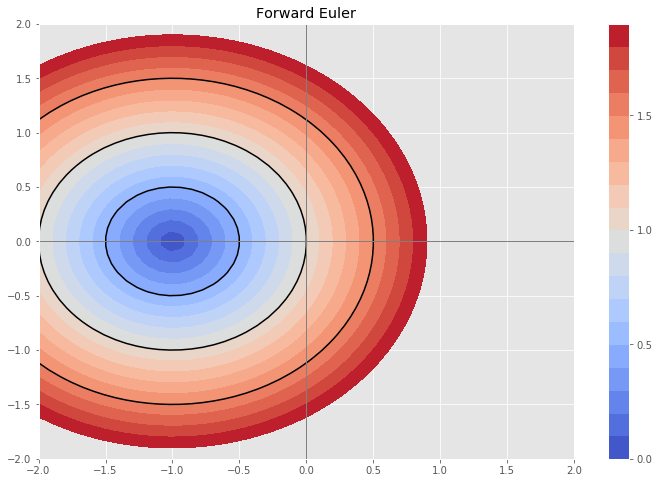

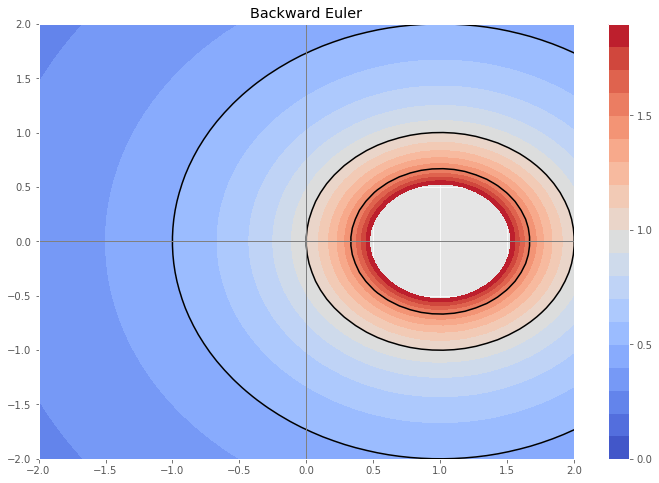

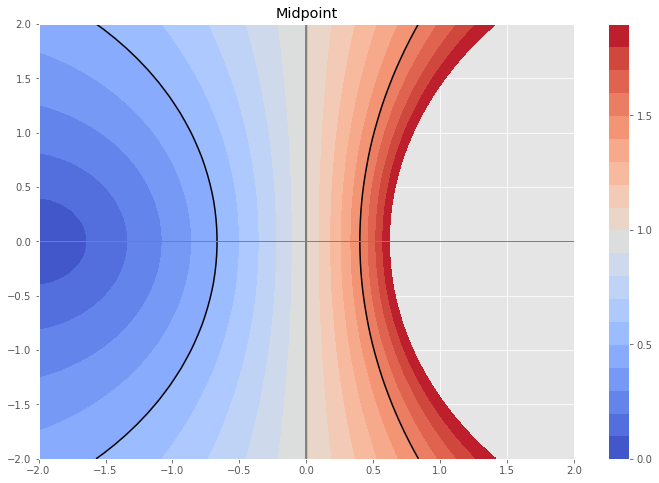

In [35]:
def plot_stability(x, y, Rz, label):
    plt.figure()
    C = plt.contourf(xx, yy, np.abs(Rz), np.arange(0,2,.1), cmap=plt.cm.coolwarm)
    plt.colorbar(C, ticks=np.linspace(0, 2, 5))
    plt.axvline(x=0, linewidth=1, color='grey')
    plt.axhline(y=0, linewidth=1, color='grey')
    plt.contour(xx, yy, np.abs(Rz), np.arange(0,2,.5), colors='k')
    plt.title(label)

x = np.linspace(-2,2)
xx, yy = np.meshgrid(x, x)
zz = xx + 1j*yy
Rlist = [('Forward Euler', 1+zz),
        ('Backward Euler', 1/(1-zz)),
        ('Midpoint', (1+zz/2)/(1-zz/2))]
for Rlabel, R in Rlist:
    plot_stability(xx, yy, R, Rlabel)

We can capture all of these methods in a family known as the $\theta$ method.

We'll model our cosine decay equation as

$$ \dot u = \underbrace{A}_{-k} u + \underbrace{s(t)}_{k \cos t} $$

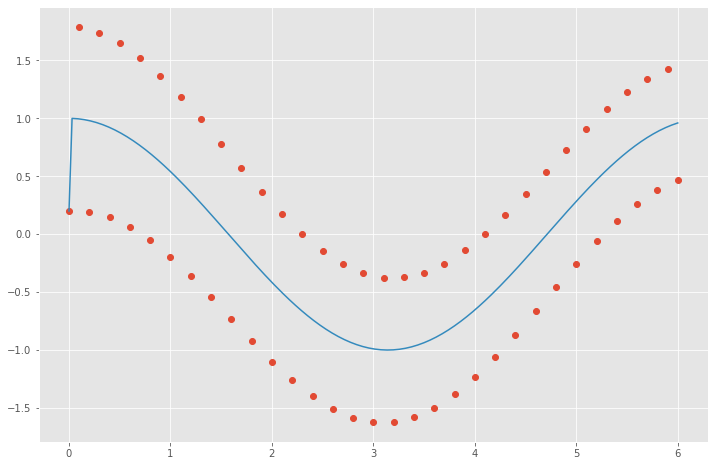

In [77]:
def ode_theta_linear(A, u0, source, bcs=[], tfinal=1, h=0.1, theta=.5):
    u = u0.copy()
    t = 0.
    thist = [t]
    uhist = [u0]
    A = np.array(A, ndmin=2)
    I = np.eye(*A.shape)
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        rhs = (I + (1-theta)*h*A) @ u + h*source(t+theta*h)
        for i, f in bcs:
            rhs[i] = theta*h*f(t+theta*h, x[i])
        u = np.linalg.solve(I - theta*h*A, rhs)
        t = tnext
        thist.append(t)
        uhist.append(u.copy())
    return np.array(thist), np.array(uhist)

test = fcos(k=5000)
u0 = np.array([.2])
hist = ode_theta_linear(-test.k, u0,
                        lambda t: test.k*np.cos(t),
                        h=.1, tfinal=6, theta=.5)
plt.plot(hist[0], hist[1], 'o')
tt = np.linspace(0, 6, 200)
plt.plot(tt, test.u(tt,u0));

#### Observations

* $\theta=1$ is robust
* $\theta=1/2$ gets correct long-term behavior, but has oscillations at early times
* $\theta < 1/2$ allows oscillations to grow

We say that a problem is **stiff** when it has multiple time scales and the slower time scales can be approximated using larger steps than would be needed to resolve the fast scales.  This usually means that explicit methods are limited by stability rather than accuracy, and we should choose implicit methods to efficiently approximate the slow/long-term dynamics.  Examples of stiff problems:

* Diffusion
* Elastic waves in quasi-static simulation
* Chemical reactions
* Low-Mach flows*

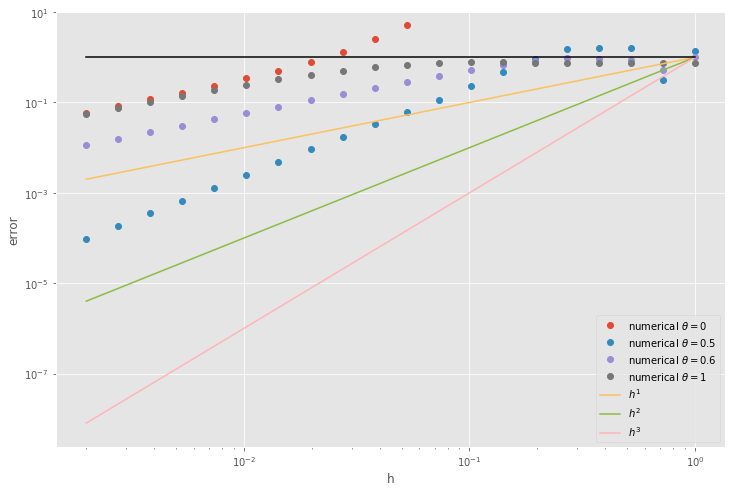

In [94]:
class flinear:
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, u):
        return self.A @ u
    def u(self, t, u0):
        from scipy.linalg import expm
        return expm(self.A*t) @ u0

def mms_error(h, theta):
    test = flinear(np.array([[0, 5], [-5, 0]]))
    u0 = np.array([1, 0])
    thist, uhist = ode_theta_linear(test.A, u0,
                                    lambda t: 0*u0, h=h, tfinal=3,
                                    theta=theta)
    return np.linalg.norm(uhist[-1] - test.u(thist[-1], u0), np.inf)

hs = np.geomspace(.002, 1, 20)
for theta in [0, .5, 0.6, 1]:
    errors = [mms_error(h, theta) for h in hs]
    plt.loglog(hs, errors, 'o', label=f'numerical $\\theta = {theta}$')
for p in range(1,4):
    plt.loglog(hs, hs**p, label='$h^{%d}$'%p)
plt.loglog(hs, 0*hs+1, 'k')
plt.xlabel('h')
plt.ylabel('error')
plt.legend(loc='lower right')
plt.ylim(top=10);

* Only $\theta = 0.5$ converges at second order (slope matches the $h^2$ line).
* $\theta=0$ becomes unstable at a step size where $\theta=1$ already has very poor accuracy, but $\theta=0.5$ is less than 10% error.
* All stable methods have $O(1)$ error for sufficiently large steps.
* High order explicit methods (beyond the scope of this class, but widely available) could be much more accurate for sufficiently small steps, but would still not be stable with arbitrarily large time steps.

### Automatic step size control

Some dynamical systems have rapid transitions that need short time steps, but long periods of slow dynamics in which large steps are possible.  Adaptive controllers can automatically choose step sizes for efficiency gains.  An example from chemical kinetics, using petsc4py:

![](oregonator.png)

### Evaluating accuracy and performance

Each method has an order of accuracy

* error is $O(h^p)$
  * larger $p$ is important if you need lots of accuracy
  * you might not need extreme accuracy
  * accuracy might be limited by other approximations (collisions, spatial discretization, ...)
* multi-stage vs multi-step
  * Runge-Kutta methods take larger steps, but need to do work on each "stage"
  * Rosenbrock methods can amortize costs over the stages
* Newton and Krylov methods might not converge (or converge more slowly) when taking steps that are too long
  * maybe need better preconditioners, multigrid, etc.
  * or choose smaller time steps
  * revisit formulation
* adaptive error control
  * mostly heuristic, assuming asymptotic range
  * controller stability

![](HairerWanner-WorkPrecision.png)

#### Further reading

* Hairer, Nørsett, and Wanner, [**Solving Ordinary Differential Equations I: Nonstiff Problems**](https://link.springer.com/book/10.1007%2F978-3-540-78862-1)
* Hairer and Wanner, [**Solving Ordinary Differential Equations II: Stiff and Differential-Algebraic Problems**](https://link.springer.com/book/10.1007%2F978-3-642-05221-7)